# SHAP values for skforecast models

SHAP (SHapley Additive exPlanations) values are a popular method for explaining machine learning models, as they help to understand how variables and values influence predictions visually and quantitatively.

It is possible to generate SHAP-values explanations from Skforecast models with just two essential elements:

+ The internal regressor of the forecaster.

+ The training matrices created from the time series and used to fit the forecaster.

By leveraging these two components, users can create insightful and interpretable explanations for their skforecast models. These explanations can be used to verify the reliability of the model, identify the most significant factors that contribute to model predictions, and gain a deeper understanding of the underlying relationship between the input variables and the target variable.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

See also: <a href="https://skforecast.org/latest/user_guides/feature-importances.html">Feature importances</a>

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import shap
shap.initjs()
from sklearn.ensemble import HistGradientBoostingRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

## Data

In [2]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o_exog.csv'
)
data = pd.read_csv(
            url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2']
       )

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()
data.head(3)

,y,exog_1,exog_2
datetime,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942


## Create and train forecaster

In [3]:
# Create recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = 5
             )

forecaster.fit(
    y    = data['y'],
    exog = data[['exog_1', 'exog_2']]
)

## Training matrices 

In [4]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                        y    = data['y'],
                        exog = data[['exog_1', 'exog_2']]
                    )
display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,exog_1,exog_2
datetime,,,,,,,
1992-09-01,0.475463,0.483389,0.410534,0.361801,0.379808,0.959610,1.153190
1992-10-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.956205,1.194551
1992-11-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.949715,1.231489


datetime
1992-09-01    0.534761
1992-10-01    0.568606
1992-11-01    0.595223
Freq: MS, Name: y, dtype: float64

## Shap Values

### Shap explainer

The python implementation of [SHAP](https://shap.readthedocs.io/en/latest/index.html) is built along the explainers. These explainers are appropriate only for certain types or classes of algorithms. For example, the TreeExplainer is used for tree-based models.

In [5]:
# Create SHAP explainer
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)
shap_values = explainer.shap_values(X_train)

### SHAP Summary Plot

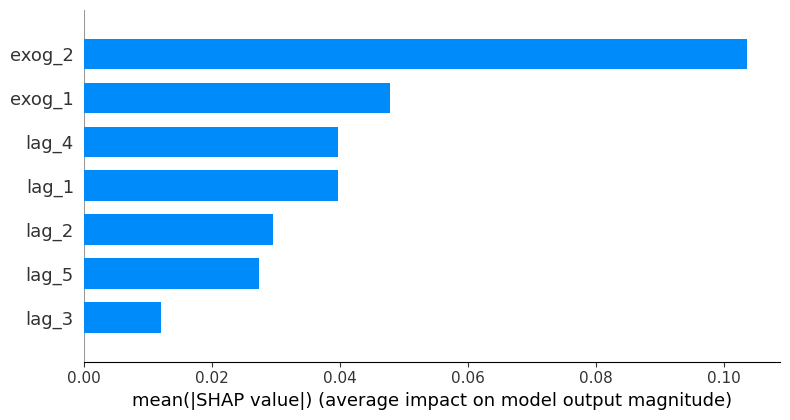

In [6]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

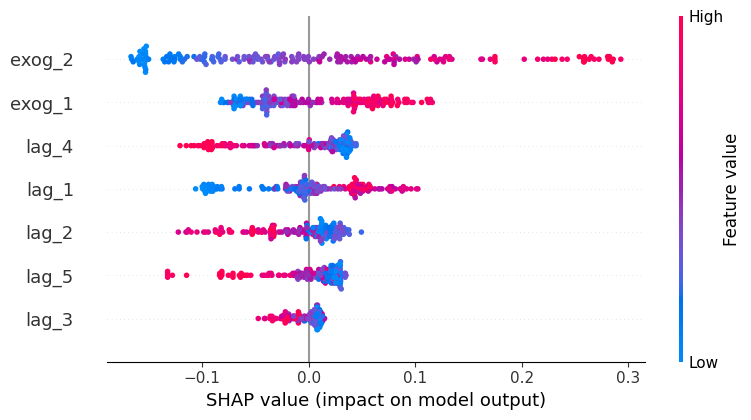

In [7]:
shap.summary_plot(shap_values, X_train)

### Explain predictions

**Visualize a single prediction**

In [8]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

**Visualize many predictions**

In [9]:
# visualize the first 200 training set predictions
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

### SHAP Dependence Plots

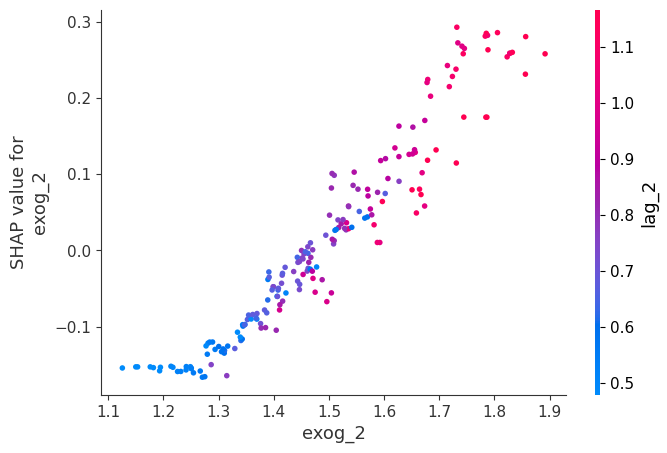

In [10]:
shap.dependence_plot("exog_2", shap_values, X_train)

In [11]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>